New logic: Swire would want to predict the abandonment couple of days before the end of the window. 
Fit training data with cart abandonment but only up to the last 2 windows of puchase or abandon. 
Then for the test data, test/predict only couples days in not wait untill the end of the window. 

In [156]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# Clean google analytics.csv and join with customer.csv 


In [2]:
ga = pd.read_csv("Copy of google_analytics.csv")
pd.set_option('display.max_columns', None)
ga.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS
0,501508595,2025-04-07,2025-04-07T14:57:40.713Z,view_search_results,mobile,Samsung,Android,Product List,NaN,[]
1,501730915,2025-04-07,2025-04-07T19:28:54.546Z,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id..."
2,501567329,2025-04-07,2025-04-07T21:40:56.281Z,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id..."
3,501765083,2025-04-08,2025-04-08T06:06:36.717Z,user_engagement,mobile,Apple,iOS,NaN,NaN,[]
4,501707837,2025-04-08,2025-04-08T18:12:10.511Z,view_item_list,desktop,Google,Windows,MyCoke Orders,Category: All Products,"[{""item_id"":""412588"",""quantity"":""1""},{""item_id..."


In [3]:
# Getting only cart affected events
ga_cart_events = ga[ga['EVENT_NAME'].isin(['add_to_cart', 'remove_from_cart','purchase'])]

In [4]:
# Join customer.csv with ga_cart_events to get customer's local time 
customer = pd.read_csv('Copy of customer.csv')

customer_ga_cart_events = pd.merge(ga_cart_events, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

In [5]:
from zoneinfo import ZoneInfo
import pandas as pd

# ---- 1) City → timezone map (as you had) ----
city_tz = {
    "Tacoma, WA":"America/Los_Angeles","Spokane, WA":"America/Los_Angeles",
    "Arlington, WA":"America/Los_Angeles","Bellevue, WA":"America/Los_Angeles",
    "Walla Walla, WA":"America/Los_Angeles","Reno, NV":"America/Los_Angeles",
    "Elko, NV":"America/Los_Angeles","Pendleton, OR":"America/Los_Angeles",
    "Eugene, OR":"America/Los_Angeles","Wilsonville, OR":"America/Los_Angeles",
    "Bend, OR":"America/Los_Angeles","LaGrande, OR":"America/Los_Angeles",
    "Lewiston, ID":"America/Los_Angeles","Wenatchee, WA":"America/Los_Angeles",
    "Bremerton, WA":"America/Los_Angeles",
    "Denver, CO":"America/Denver","Colorado Springs, CO":"America/Denver",
    "Grand Junction, CO":"America/Denver","Glenwood Springs, CO":"America/Denver",
    "Pueblo, CO":"America/Denver","Alamosa, CO":"America/Denver",
    "Johnstown, CO":"America/Denver","Cheyenne, WY":"America/Denver",
    "Richfield, UT":"America/Denver","Draper, UT":"America/Denver",
    "Logan, UT":"America/Denver","Ogden, UT":"America/Denver",
    "Price, UT":"America/Denver","Albuquerque, NM":"America/Denver",
    "Scottsbluff, NE":"America/Denver",
    "Boise, ID":"America/Boise","Idaho Falls, ID":"America/Boise","Pocatello, ID":"America/Boise",
    "Tempe, AZ":"America/Phoenix","Tucson, AZ":"America/Phoenix",
    "Prescott, AZ":"America/Phoenix","Glendale, AZ":"America/Phoenix",
    "Kingman, AZ":"America/Phoenix","Huachuca City, AZ":"America/Phoenix",
    "Show Low, AZ":"America/Phoenix","Flagstaff, AZ":"America/Phoenix",
    "Yuma, AZ":"America/Phoenix",
}

# ---- 2) Parse timestamp as UTC (kept your column name) ----
customer_ga_cart_events["EVENT_TIMESTAMP_UTC"] = pd.to_datetime(
    customer_ga_cart_events["EVENT_TIMESTAMP"], utc=True, errors="coerce"
)

# ---- 3) Map timezone from CITY (use CITY consistently) ----
customer_ga_cart_events["TIMEZONE"] = customer_ga_cart_events["SALES_OFFICE_DESCRIPTION"].map(city_tz)

# ---- 4) Convert to local datetime per-row (only when TIMEZONE present) ----
customer_ga_cart_events["EVENT_LOCAL_DT"] = customer_ga_cart_events.apply(
    lambda row: (
        row["EVENT_TIMESTAMP_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["EVENT_TIMESTAMP_UTC"])
        else pd.NaT
    ),
    axis=1
)

# ---- 5) Convenience columns: date / hour / day-of-week ----
customer_ga_cart_events["EVENT_LOCAL_DATE"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.date() if pd.notna(v) else pd.NaT
)
customer_ga_cart_events["EVENT_LOCAL_TIME"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.strftime("%I:%M:%S %p") if pd.notna(v) else pd.NA
)
customer_ga_cart_events["EVENT_LOCAL_DOW"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.day_name() if pd.notna(v) else pd.NA
)

# ---- 6) Drop duplicates (use the actual UTC column name) ----
customer_ga_cart_events = customer_ga_cart_events.drop_duplicates(
    subset=["CUSTOMER_ID","EVENT_TIMESTAMP_UTC","EVENT_NAME"],
    keep="first"
)

# ---- 7) Select relevant columns (use consistent names) ----
cols = [
    "CUSTOMER_ID","CITY","TIMEZONE","EVENT_NAME",
    "EVENT_LOCAL_TIME","EVENT_LOCAL_DT","EVENT_LOCAL_DATE",
    "EVENT_LOCAL_HOUR","EVENT_LOCAL_DOW",
    "DEVICE_CATEGORY","DEVICE_MOBILE_BRAND_NAME","DEVICE_OPERATING_SYSTEM",
    "EVENT_PAGE_NAME","EVENT_PAGE_TITLE"
]
existing_cols = [c for c in cols if c in customer_ga_cart_events.columns]
customer_ga_cart_events = customer_ga_cart_events[existing_cols]

customer_ga_cart_events.head()


,CUSTOMER_ID,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,501567329,America/Los_Angeles,purchase,02:40:56 PM,2025-04-07 14:40:56.281000-07:00,2025-04-07,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order
1,501702910,America/Denver,add_to_cart,12:30:14 PM,2025-05-24 12:30:14.025000-06:00,2025-05-24,Saturday,desktop,Google,Windows,NaN,Search
2,501565777,America/Phoenix,add_to_cart,01:08:07 PM,2025-05-20 13:08:07.167000-07:00,2025-05-20,Tuesday,mobile,Samsung,Android,NaN,Search
3,501752380,America/Los_Angeles,add_to_cart,02:25:29 PM,2025-05-16 14:25:29.494000-07:00,2025-05-16,Friday,desktop,Apple,Macintosh,NaN,Search
4,500549947,America/Los_Angeles,add_to_cart,06:12:45 PM,2025-04-07 18:12:45.609000-07:00,2025-04-07,Monday,mobile,Apple,iOS,Product List,NaN


# The windows from master.csv

In [6]:
windows = pd.read_csv('master.csv')

In [7]:
pd.set_option('display.max_columns', None)

windows.head()

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD
0,219,500245685,2024-06-10,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-06-17
1,220,500245685,2024-06-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-06-24
2,221,500245685,2024-06-24,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-01
3,222,500245685,2024-07-01,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-08
4,223,500245685,2024-07-08,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-15


# windows join customer_ga_cart_events

Join exploded windows to Google Analytics, with cart events only.

Left merge from windows and filter for correct dates of GA within windows. 

In [43]:
# Ensure datetime types
windows["ANCHOR_DATE"] = pd.to_datetime(windows["ANCHOR_DATE"])
windows["NEXT_ANCHOR_SAME_WD"] = pd.to_datetime(windows["NEXT_ANCHOR_SAME_WD"])
customer_ga_cart_events["EVENT_LOCAL_DATE"] = pd.to_datetime(customer_ga_cart_events["EVENT_LOCAL_DATE"])

# Perform a LEFT merge (windows = left table)
windows_with_ga = pd.merge(
    windows,
    customer_ga_cart_events,
    on="CUSTOMER_ID",
    how="left"
)


windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
    windows_with_ga["ANCHOR_DATE"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],   #CUTOFFTIME__C	?
    errors="coerce"
)
windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(
    windows_with_ga["NEXT_ANCHOR_SAME_WD"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],
    errors="coerce"
)

# 2) Drop timezone from the event’s local datetime so it’s naive too
windows_with_ga["EVENT_LOCAL_NAIVE"] = windows_with_ga["EVENT_LOCAL_DT"].apply(
    lambda v: pd.NaT if pd.isna(v) else pd.Timestamp(v).tz_localize(None)
)

# 1) Build in-window mask (compare naive-to-naive)
in_window = (
    (windows_with_ga["EVENT_LOCAL_NAIVE"] >= windows_with_ga["WINDOW_START_LOCAL"]) &
    (windows_with_ga["EVENT_LOCAL_NAIVE"] <  windows_with_ga["WINDOW_END_LOCAL"])
)

windows_with_ga = windows_with_ga[in_window].copy()





C:\Users\dhung\AppData\Local\Temp\ipykernel_14204\281581639.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
C:\Users\dhung\AppData\Local\Temp\ipykernel_14204\281581639.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(


This is all the GA cart events for each windows. Each windows migh have many events (unaggreagated)

In [44]:
windows_with_ga[windows_with_ga['CUSTOMER_ID']==501730915]

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE
6916472,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:47:12 AM,2024-11-18 08:47:12.263000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:12.263
6916474,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:49:59 AM,2024-11-18 08:49:59.113000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:49:59.113
6916478,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:47:45 AM,2024-11-18 08:47:45.663000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:45.663
6916486,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:54:16 AM,2024-11-18 08:54:16.470000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:54:16.470
6916496,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,purchase,08:56:09 AM,2024-11-18 08:56:09.930000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Order,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:56:09.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6918617,975665,501730915,2025-05-08,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-15,America/Boise,purchase,02:00:11 PM,2025-05-12 14:00:11.669000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 14:00:11.669
6918627,975665,501730915,2025-05-08,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-15,America/Boise,add_to_cart,01:59:19 PM,2025-05-12 13:59:19.895000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Orders - Product:,Category: Energy Drinks,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 13:59:19.895
6918633,975665,501730915,2025-05-08,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-15,America/Boise,add_to_cart,01:58:44 PM,2025-05-12 13:58:44.112000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Order Builder,Order Builder,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 13:58:44.112
6918727,975666,501730915,2025-05-15,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-22,America/Boise,add_to_cart,09:06:00 PM,2025-05-19 21:06:00.765000-06:00,2025-05-19,Monday,desktop,Google,Windows,MyCoke Order Builder,Order Builder,2025-05-15 15:00:00,2025-05-22 15:00:00,2025-05-19 21:06:00.765


# New logic for GA cutoff date

Add a new cutoff date for the Predictive model, per each frequency

In [112]:
windows_with_ga1=windows_with_ga.copy()
# What are the top frequencies for customers
windows_with_ga1.groupby('WINDOW_FREQUENCY')['CUSTOMER_ID'].nunique()


WINDOW_FREQUENCY
7     3029
14    1140
21      17
28    1469
Name: CUSTOMER_ID, dtype: int64

In [113]:
# Frequency cutoff change as needed
frequency_cutoff = {
    7:2,
    14:2,
    21:2,
    28:2}

#New column
windows_with_ga1["event_cutoff_days"] = windows_with_ga1["WINDOW_FREQUENCY"].map(frequency_cutoff)


In [114]:
windows_with_ga1["WINDOW_END_LOCAL_event_cutoff"] = (
    windows_with_ga1["WINDOW_END_LOCAL"]
    - pd.to_timedelta(windows_with_ga1["event_cutoff_days"], unit="D")
)


In [115]:
#Flag EVENT_LOCAL_NAIVE not within WINDOW_START_LOCAL - WINDOW_END_LOCAL_event_cutoff
windows_with_ga1['event_within_new_cutoff'] = (
    windows_with_ga1['EVENT_LOCAL_NAIVE'] <= windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']
)


In [116]:
# Which window have high cutoff rate, so we could tweak the dict above
freq_cutoff_summary = (
    windows_with_ga1
    .groupby("WINDOW_FREQUENCY")["event_within_new_cutoff"]
    .mean()
    .sort_values(ascending=False)
)
print(freq_cutoff_summary)
print(f'Total len before cutoff for new logic {len(windows_with_ga1)}')


WINDOW_FREQUENCY
28    0.951388
21    0.931034
14    0.880013
7     0.756354
Name: event_within_new_cutoff, dtype: float64
Total len before cutoff for new logic 249148


In [117]:
#Get rows of data that the events are within the new cutoff date
windows_with_ga1 = windows_with_ga1[windows_with_ga1['event_within_new_cutoff']==True]
print(f'Total len after cutoff {len(windows_with_ga1)}')

Total len after cutoff 200565


# Aggregation

In [118]:
# Add events count before aggregations
windows_with_ga1["add_to_cart_count"] = (windows_with_ga1["EVENT_NAME"] == "add_to_cart").astype("int")
windows_with_ga1["purchase_count"] = (windows_with_ga1["EVENT_NAME"] == "purchase").astype("int")
windows_with_ga1["remove_from_cart_count"] = (windows_with_ga1["EVENT_NAME"] == "remove_from_cart").astype("int")


In [119]:
# How to agg EVENT_PAGE_TITLE?
with pd.option_context('display.max_rows', None):
    display(windows_with_ga1.groupby("EVENT_PAGE_TITLE").size())


EVENT_PAGE_TITLE
Cart                                                 20348
Category                                               169
Category: All Products                               46242
Category: CO2                                         1424
Category: Coffee and Coffee Drinks                     861
Category: Cups / Lids                                  776
Category: Cups/Lids                                     66
Category: Cups/Lids/Straws                              20
Category: DP20oz                                         1
Category: Dairy                                       2354
Category: Energy Drinks                               6185
Category: Enhanced Water                              2192
Category: Flavors / Mixers / Sweeteners                592
Category: Flavors/Mixers/Sweeteners                     66
Category: Freestyle Products                           526
Category: Imports                                      618
Category: Juice and Juice Drinks       

In [120]:
# How to agg EVENT_PAGE_NAME
windows_with_ga1.groupby("EVENT_PAGE_NAME").size()


EVENT_PAGE_NAME
Cart Screen                                    2854
MyCoke Dashboard                               2327
MyCoke Invoices                                  18
MyCoke Order Builder                           3003
MyCoke Order History                              3
MyCoke Orders                                 64676
MyCoke Orders - Cart                          27438
MyCoke Orders - Product:                      18359
MyCoke Orders - Purchase Success              24183
MyCoke Product List - Category:                 190
MyCoke Support History - Customer Services       26
Product Details                                 421
Product List                                   5691
Public About MyCoke                              27
dtype: int64

In [121]:
windows_with_ga1 

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,event_cutoff_days,WINDOW_END_LOCAL_event_cutoff,event_within_new_cutoff,add_to_cart_count,purchase_count,remove_from_cart_count
506,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,2,2025-02-22 17:00:00,True,0,0,1
507,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,2,2025-02-22 17:00:00,True,0,0,1
509,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,2,2025-02-22 17:00:00,True,0,0,1
513,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,2,2025-02-22 17:00:00,True,0,1,0
514,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,2,2025-02-22 17:00:00,True,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9918259,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,add_to_cart,03:41:57 PM,2025-05-06 15:41:57.827000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,MyCoke Orders - Product:,Category: All Products,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:41:57.827,2,2025-05-14 17:00:00,True,1,0,0
9918260,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,add_to_cart,03:28:41 PM,2025-05-06 15:28:41.041000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,NaN,Search,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:28:41.041,2,2025-05-14 17:00:00,True,1,0,0
9918261,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,remove_from_cart,03:44:03 PM,2025-05-06 15:44:03.886000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,MyCoke Orders - Cart,Cart,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:44:03.886,2,2025-05-14 17:00:00,True,0,0,1
9918262,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,add_to_cart,03:33:56 PM,2025-05-06 15:33:56.744000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,NaN,Search,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:33:56.744,2,2025-05-14 17:00:00,True,1,0,0


In [122]:
windows_with_ga2=windows_with_ga1.copy()

windows_with_ga2 = (
    windows_with_ga2
    .groupby(["CUSTOMER_ID","WINDOW_START_LOCAL","WINDOW_END_LOCAL","WINDOW_END_LOCAL_event_cutoff"], as_index=False)
    .agg(
        SALES_OFFICE=("SALES_OFFICE_x","first"),
        SHIPPING_CONDITIONS_DESC=("SHIPPING_CONDITIONS_DESC","first"),
        WEEK_DAY_OF_ANCHOR_DATE=("WEEK_DAY_OF_ANCHOR_DATE","first"),
        WINDOW_FREQUENCY=("WINDOW_FREQUENCY","first"),
        DISTRIBUTION_MODE_DESC=("DISTRIBUTION_MODE_DESC","first"),
        CUTOFFTIME__C=("CUTOFFTIME__C", "first"),
        TIMEZONE=("TIMEZONE","first"),

        add_to_cart_count=("add_to_cart_count","sum"),
        remove_from_cart_count=("remove_from_cart_count","sum"),
        purchase_count=("remove_from_cart_count","sum"),
        
        first_event_time=("EVENT_LOCAL_NAIVE", "min"),   # earliest event in window
        last_event_time=("EVENT_LOCAL_NAIVE", "max"),    # Latest event in window
        duration_min_max_event=("EVENT_LOCAL_NAIVE", lambda x: x.max() - x.min()), #duration in between events (usually, because this is hours could span many days
        mode_event_day = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.day.mode().iloc[0]),
        mode_event_month = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.month.mode().iloc[0]),
        mode_event_dow = ("EVENT_LOCAL_DOW", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        device_event_device = ("DEVICE_CATEGORY", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_mobile_brand = ("DEVICE_MOBILE_BRAND_NAME", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_os = ("DEVICE_OPERATING_SYSTEM", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),


        #EVENT_PAGE_NAME
        total_events=("EVENT_NAME", "count"),
        # --- Simple page groups ---
        cart_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Cart Screen","MyCoke Orders - Cart","MyCoke Orders - Purchase Success"]).sum()),
        product_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Product List","Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).sum()),
        order_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["MyCoke Orders","MyCoke Order Builder"]).sum()),
        # --- Simple yes/no (1/0) flags ---
        visited_cart=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Cart Screen","MyCoke Orders - Cart","MyCoke Orders - Purchase Success"]).any())),
        visited_product=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Product List", "Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).any())),
        visited_order=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["MyCoke Orders","MyCoke Order Builder" ]).any())),


        event_cutoff_days = ('event_cutoff_days', 'min' )



    )
)

Each row is a window with aggreagated GA data, uncutoff the GA data before certain day for ML


In [131]:
print(len(windows_with_ga2))
windows_with_ga2[windows_with_ga2['CUSTOMER_ID']==500245738].head()

26574


,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,WINDOW_END_LOCAL_event_cutoff,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,TIMEZONE,add_to_cart_count,remove_from_cart_count,purchase_count,first_event_time,last_event_time,duration_min_max_event,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order,event_cutoff_days
4,500245738,2024-08-09 15:30:00,2024-08-16 15:30:00,2024-08-14 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,1,0,0,2024-08-09 16:06:54.105,2024-08-09 16:07:59.610,0 days 00:01:05.505000,9,8,Friday,desktop,Microsoft,Windows,2,1,0,1,1,0,1,2
5,500245738,2024-08-16 15:30:00,2024-08-23 15:30:00,2024-08-21 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,1,0,0,2024-08-20 16:31:20.567,2024-08-20 16:31:20.567,0 days 00:00:00,20,8,Tuesday,desktop,Microsoft,Windows,1,0,0,1,0,0,1,2
6,500245738,2024-09-13 15:30:00,2024-09-20 15:30:00,2024-09-18 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,1,0,0,2024-09-18 14:34:00.789,2024-09-18 14:35:34.602,0 days 00:01:33.813000,18,9,Wednesday,desktop,Microsoft,Windows,2,1,0,1,1,0,1,2
7,500245738,2024-09-20 15:30:00,2024-09-27 15:30:00,2024-09-25 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,3,3,3,2024-09-24 15:08:02.590,2024-09-24 16:17:39.089,0 days 01:09:36.499000,24,9,Tuesday,desktop,Microsoft,Windows,7,4,0,3,1,0,1,2
8,500245738,2024-10-25 15:30:00,2024-11-01 15:30:00,2024-10-30 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,2,0,0,2024-10-30 13:57:09.570,2024-10-30 14:00:30.206,0 days 00:03:20.636000,30,10,Wednesday,desktop,Microsoft,Windows,3,1,0,1,1,0,1,2


# Modeling

In [143]:
# Preparing the target variable
windows_with_ga3=windows_with_ga2.copy()

windows_with_ga3['target_abandon'] = (windows_with_ga3['purchase_count']<1).astype("int64")
windows_with_ga3.drop(columns=['purchase_count'], inplace=True)


New abandonment rate is 0.6112


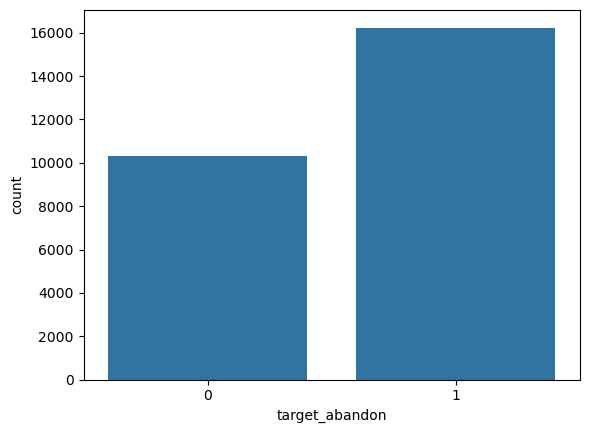

In [147]:
# New abandon rate?
print(f'New abandonment rate is {windows_with_ga3['target_abandon'].mean():.4f}')

sns.countplot(data=windows_with_ga3, x='target_abandon')
plt.show()

In [160]:
windows_with_ga3.columns.isna().sum()

0

In [163]:
# Split the data
x = windows_with_ga3.drop(columns=['target_abandon'])
y = windows_with_ga3['target_abandon']

x = x.replace({pd.NA: np.nan})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=12345,
    stratify=y  # keeps same balance of 0/1 in train and test
)



## Logsitc model

In [165]:

numeric_cols = x_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = x_train.select_dtypes(include=['object','category']).columns


pipeline = Pipeline(steps=[

    ("preprocess",
        ColumnTransformer(
            transformers=[
                # numeric: impute (optional) + scale
                ("num", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler())
                ]), numeric_cols),

                # categorical: impute missing, then one-hot encode
                ("cat", Pipeline(steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
                ]), categorical_cols),
            ]
        )
    ),

    ("clf",
        LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs"
        )
    )

])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline,
    x_train, y_train,
    cv=cv,
    scoring='roc_auc'
)

print("CV AUC Scores:", cv_scores)
print("Mean CV AUC:", cv_scores.mean())

# -----------------------------
# 6. Fit final model
# -----------------------------
pipeline.fit(x_train, y_train)

# -----------------------------
# 7. Evaluate on test set
# -----------------------------
y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


CV AUC Scores: [0.90964308 0.91747128 0.90870063 0.90468459 0.90906507]
Mean CV AUC: 0.9099129323021243
Test Accuracy: 0.8754468485418626
Test AUC: 0.9095710865798698
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2067
           1       0.89      0.91      0.90      3248

    accuracy                           0.88      5315
   macro avg       0.87      0.87      0.87      5315
weighted avg       0.87      0.88      0.88      5315



c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\dhung\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [171]:
pre = pipeline.named_steps["preprocess"]
clf = pipeline.named_steps["clf"]

feature_names = pre.get_feature_names_out()
coefs = clf.coef_[0]

coef_table = (
    pd.DataFrame({"feature": feature_names, "coef": coefs})
    .sort_values("coef", ascending=False)
)

with pd.option_context('display.max_rows', None):
    display(coef_table)



,feature,coef
69,cat__CUTOFFTIME__C_11:00:00 AM,0.911230
40,cat__SALES_OFFICE_G263,0.815889
102,cat__mode_event_mobile_brand_Opera Software,0.806351
72,cat__CUTOFFTIME__C_1:00:00 PM,0.697405
104,cat__mode_event_mobile_brand_T-Mobile,0.650688
22,cat__SALES_OFFICE_G161,0.513337
26,cat__SALES_OFFICE_G175,0.481216
61,cat__DISTRIBUTION_MODE_DESC_E Pallet,0.476248
21,cat__SALES_OFFICE_G152,0.456294
100,cat__mode_event_mobile_brand_Nokia,0.442896
